In [208]:
import pandas as pd
import numpy as np

from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings

In [4]:
tqdm.pandas()

In [5]:
warnings.filterwarnings('ignore')

In [6]:
scores = pd.read_hdf('data/scores_retrotesting.hd5', key='df')
moment_price = pd.read_hdf('data/ticker_price_moment_exit.hd5', key='df')

In [7]:
files = [f for f in listdir('data/intraday_data') if isfile(join('data/intraday_data', f))]

In [8]:
df_list = []
for file in files:
    temp_df = pd.read_hdf('data/intraday_data/' + file, key='df')
    df_list.append(temp_df)
intraday = pd.concat(df_list)
intraday['date'] = pd.to_datetime(intraday['time'], unit='s')
intraday['date'] = intraday['date'].dt.date
intraday['time'] = pd.to_datetime(intraday['time'], unit='s')

Для дальнейшей работы возьмем данные по тикеру AAPL (Apple) за 2021-08-25

In [9]:
aapl = intraday[intraday['ticker'] == 'AAPL']
aapl = aapl[['open', 'close', 'time', 'date', 'autofilled']]
aapl = aapl[aapl['date'] == pd.to_datetime('2021-08-25')]

In [ ]:
moment_price = moment_price[moment_price['ticker'] == 'AAPL']
moment_price = moment_price[['current_price', 'timestamp', 'news_id']]
moment_price['time'] = pd.to_datetime(moment_price['timestamp'], unit='s')
moment_price['date'] = moment_price['time'].dt.date
moment_price = moment_price[moment_price['date'] == pd.to_datetime('2021-08-25')]
moment_price.head()

Сделаем индексом время и визуализируем данные

In [11]:
aapl = aapl.set_index(aapl['time'])

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [13]:
sns.set(rc={'figure.figsize':(16, 6)})

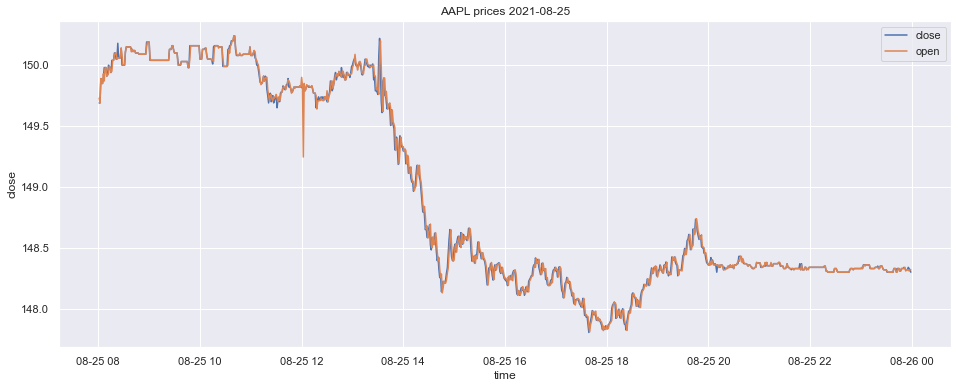

In [14]:
sns.lineplot(data=aapl['close'], palette=sns.color_palette('husl', n_colors=1)).set_title(f'AAPL prices 2021-08-25')
sns.lineplot(data=aapl['open'], palette=sns.color_palette(n_colors=1))
plt.legend(labels=["close", "open"])

Посмотрим на стационарность ряда для aapl['close'] и визуализируем автокорреляции

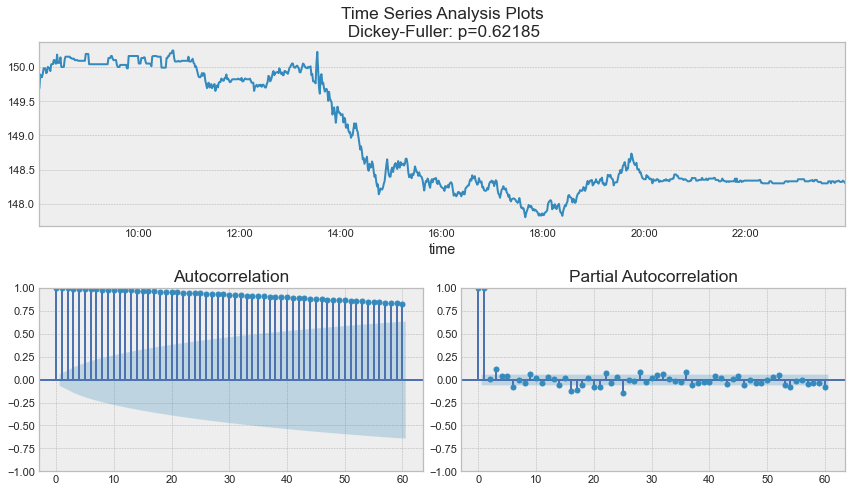

In [15]:
tsplot(aapl['close'], lags=60)

Сделаем ряд более стационарным

<AxesSubplot:xlabel='time'>

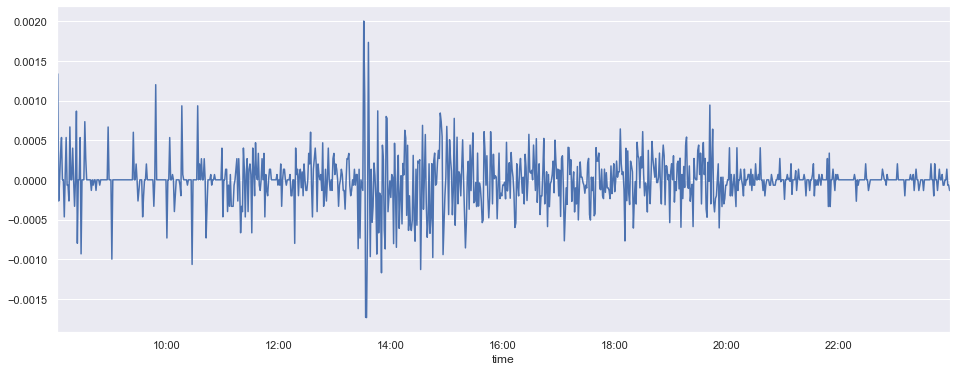

In [16]:
aapl['log'] = np.log(aapl['close'])
aapl['log_diff'] = aapl['log'] - aapl['log'].shift(1)
aapl['log_diff'].dropna().plot()

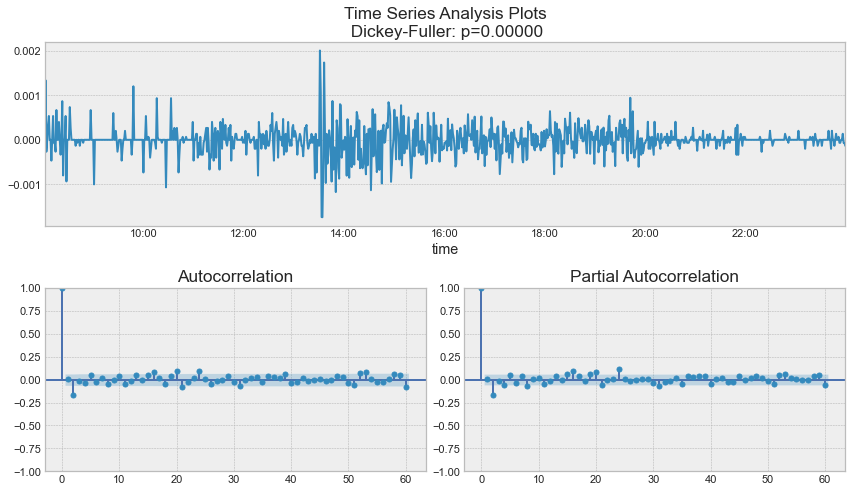

In [17]:
tsplot(aapl['log_diff'].dropna(), lags=60)

Попробуем построить модель линейной регрессии для предсказания цены закрытия в конкретную минутут по историческим данным

In [18]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

### В качестве признаков будем рассматривать сдвиги от 1 до 60

In [19]:
for i in range(1, 60):
    aapl["lag_{}".format(i)] = aapl['log_diff'].shift(i)

In [20]:
y = aapl.dropna()['log_diff']
X = aapl.dropna().drop(['log_diff', 'open', 'close', 'time', 'date', 'autofilled', 'log'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [70]:
tscv = TimeSeriesSplit(n_splits=5)

def plotModelResults(model, train=X_train, test=X_test, y_train=y_train, y_test=y_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, train, y_train,
                             cv=tscv,
                             scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [83]:
def plotCoefficients(model, train=X_train):
    coefs = pd.DataFrame(model.coef_, train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.title('Коэффициенты регрессоров')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

Для 30 лагов mape = 5.79%, посмотрим, что для 60

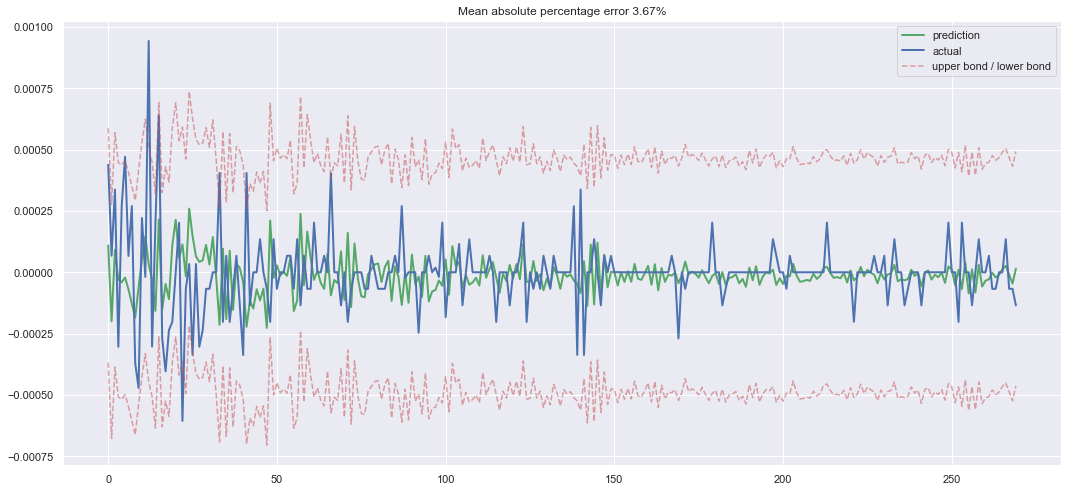

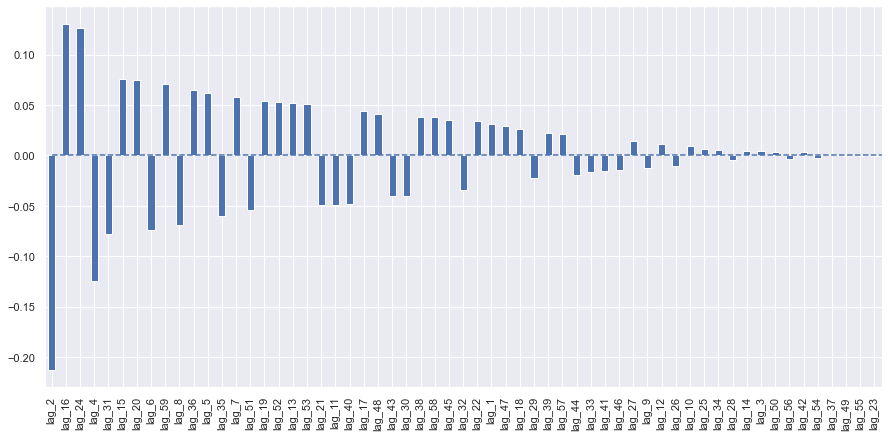

In [24]:
plotModelResults(lr, plot_intervals=True)

### Добавим признак - количество вышедших за день новостей к конкретной минуте

In [26]:
def count_news_to_time(time):
    count = moment_price[moment_price['time'] <= time].shape[0]
    return count

In [27]:
def find_news_release(time):
    index = aapl[aapl['time'].dt.floor('Min') == time.floor('Min')].index
    aapl.at[index, 'news_release'] = 1

In [ ]:
aapl['news_release'] = 0
aapl['news_count'] = aapl['time'].apply(lambda x: count_news_to_time(x))
moment_price['time'].apply(lambda x: find_news_release(x))

In [55]:
def scale(train, test):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(train)
    X_test_scaled = scaler.transform(test)
    return X_train_scaled, X_test_scaled

In [29]:
y = aapl.dropna()['log_diff']
X = aapl.dropna().drop(['log_diff', 'open', 'close', 'time', 'date', 'autofilled', 'log'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train_scaled, X_test_scaled = scale(X_train, X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

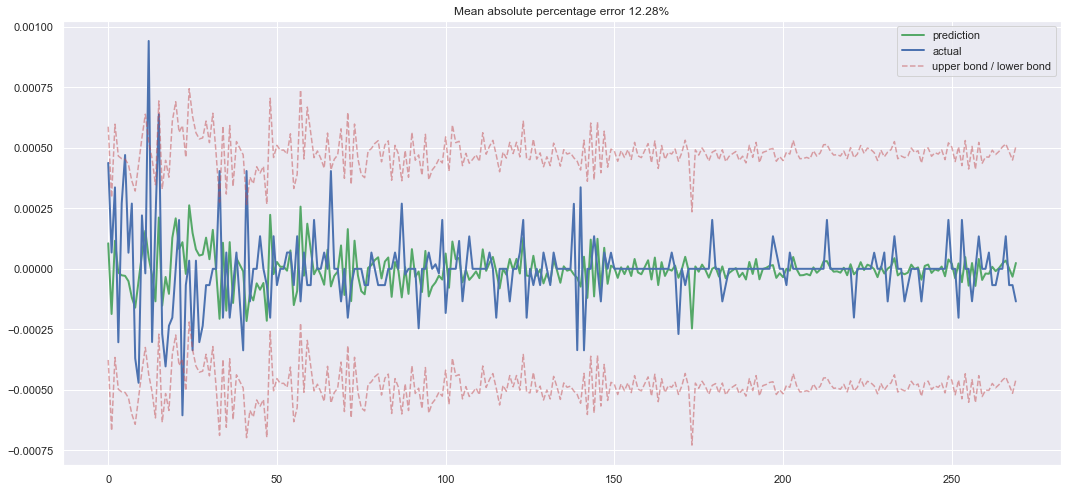

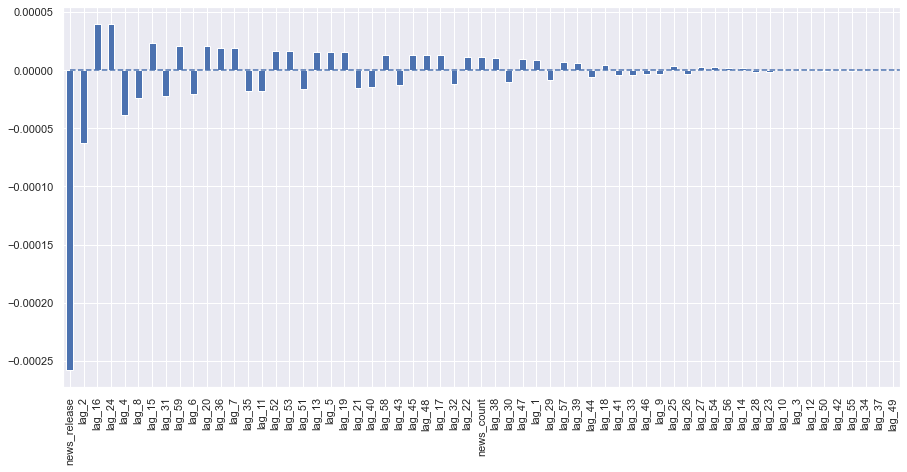

In [30]:
plotModelResults(lr, X_train_scaled, X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

### Feature selection

In [139]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [140]:
y = aapl.dropna()['log_diff']
X = aapl.dropna().drop(['log_diff', 'open', 'close', 'time', 'date', 'autofilled', 'log', 'news_count'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

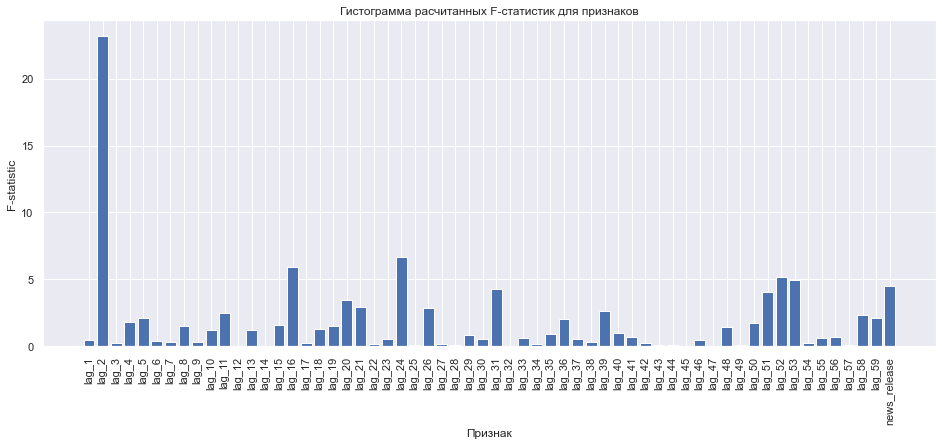

In [141]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel('Признак')
plt.ylabel('F-statistic')
plt.xticks(list(range(0, X_train.shape[1])), X_train.columns, rotation='vertical')
plt.title('Гистограмма расчитанных F-статистик для признаков')
plt.show()

In [142]:
def get_top_n_features(features, scores, n=10):
    top_n_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:n]
    return [features[i] for i in top_n_indexes]

In [153]:
def compute_errors_for_regressors(train, test, y_train=y_train, y_test=y_test, degree=1):
    errors = []

    for n in range(1, train.shape[1] + 1):
        top_features = get_top_n_features(train.columns, fs.scores_, n=n)
        poly_lr = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        poly_lr.fit(train[top_features], y_train)
        preds = poly_lr.predict(test[top_features])
        errors.append(mean_absolute_percentage_error(preds, y_test))

    plt.bar([i for i in range(len(errors))], errors)
    plt.xlabel('Количество топ-признаков')
    plt.ylabel('MAPE')
    plt.xticks([i for i in range(len(errors))], rotation='vertical')
    plt.title('MAPE для топ-n регрессоров')
    plt.show()

    return errors

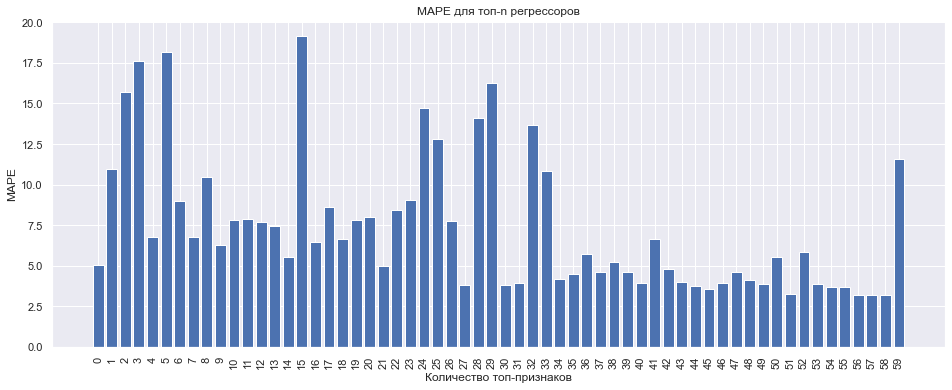

In [154]:
errors = compute_errors_for_regressors(X_train, X_test)

In [155]:
optimal_n = sorted(range(len(errors)), key=lambda x: errors[x])[0]
optimal_n

57

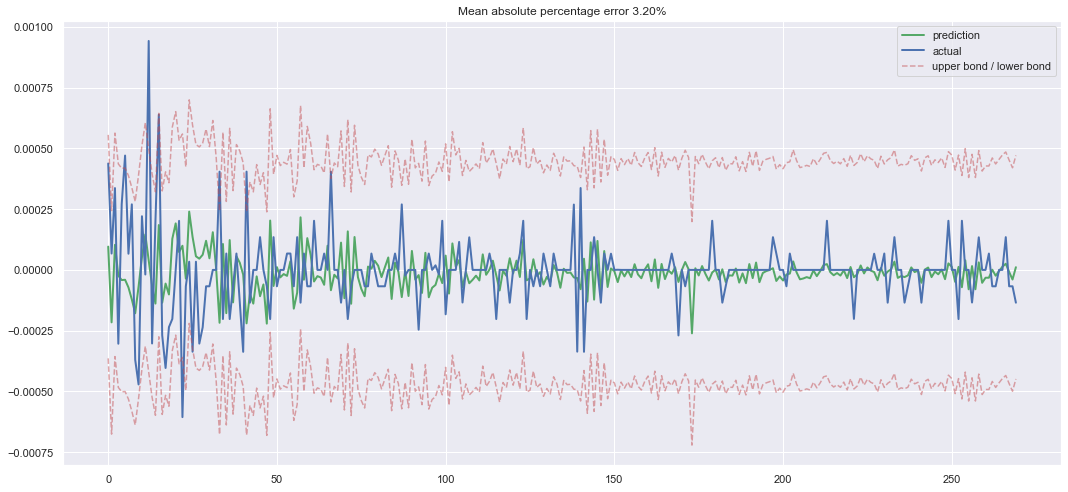

In [150]:
top_features = get_top_n_features(X_train.columns, fs.scores_, n=optimal_n)
lr = LinearRegression()
lr.fit(X_train[top_features], y_train)
plotModelResults(lr, X_train[top_features], X_test[top_features], plot_intervals=True)

### Попробуем полиномиальную регрессию на топ признаках

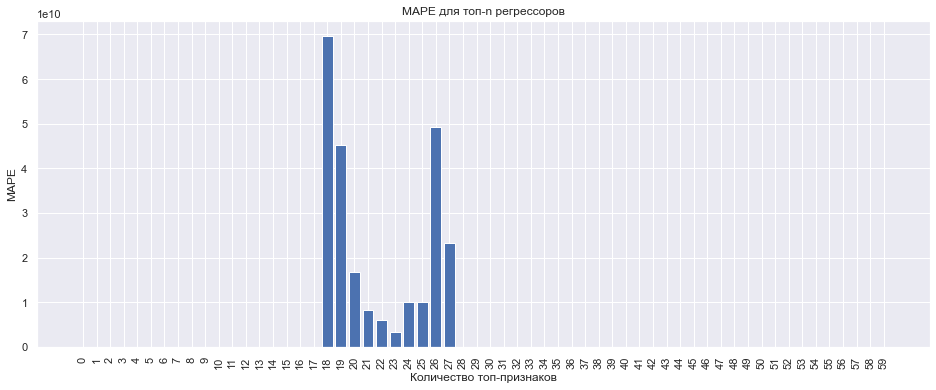

Degree: 2, min MAPE: 1.3087399557797597, optimal n: 39


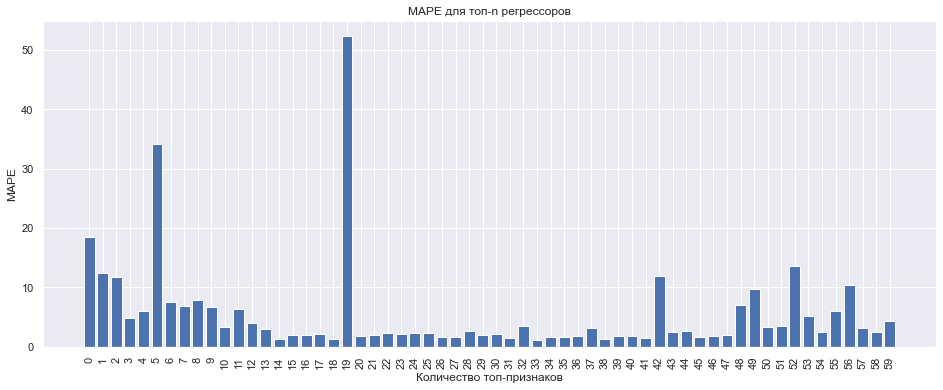

Degree: 3, min MAPE: 1.2069519171474423, optimal n: 34


In [191]:
for d in [2, 3]:
    errors = compute_errors_for_regressors(X_train, X_test, degree=d)
    optimal_n = sorted(range(len(errors)), key=lambda x: errors[x])[0] + 1
    print(f'Degree: {d}, min MAPE: {min(errors)}, optimal n: {optimal_n}')

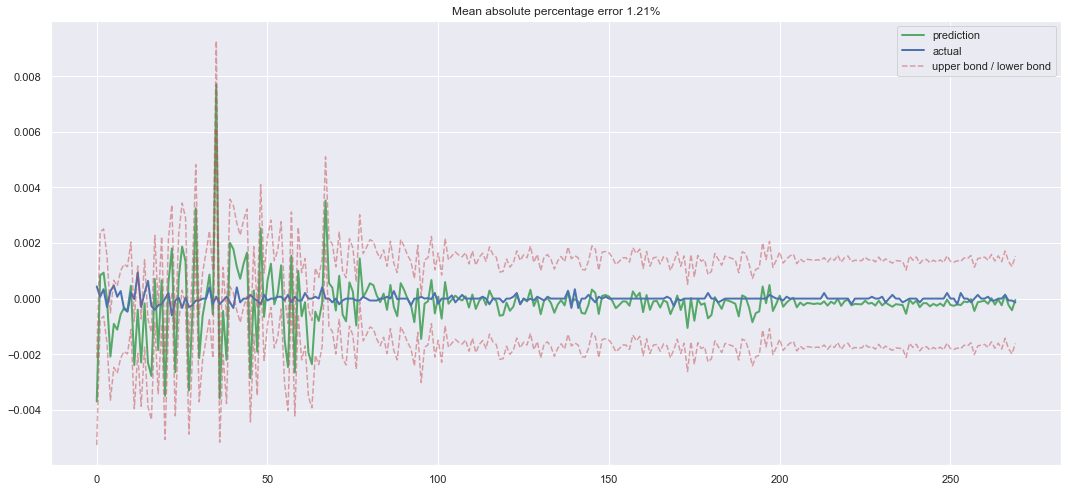

In [193]:
top_features = get_top_n_features(X_train.columns, fs.scores_, n=34)
poly_lr = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_lr.fit(X_train[top_features], y_train)

X_train_poly = poly_lr['polynomialfeatures'].transform(X_train[top_features])
X_test_poly = poly_lr['polynomialfeatures'].transform(X_test[top_features])
plotModelResults(poly_lr['linearregression'], X_train_poly, X_test_poly, plot_intervals=True)

In [194]:
mean_absolute_percentage_error(poly_lr.predict(X_test[top_features]), y_test)

1.2069519171474423